## Task 1 – Exploratory Data Analysis (EDA)

This notebook performs an exploratory data analysis on the breast cancer dataset as required by Task 1 of the assignment.

### Imports and Configuration

Imports the necessary Python libraries for data manipulation (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), preprocessing (`sklearn.preprocessing`, `sklearn.impute`) and dimensionality reduction (`sklearn.decomposition`). Basic configurations are also set, including the dataset path, target variable name (`diagnosis`), columns to drop (`id`) and a consistent plotting style using `seaborn`. The scaler for visualization (`RobustScaler`) is also defined here.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer # Import the imputer

# --- Configuration ---
# Set a consistent style for plots
sns.set(style="whitegrid")
# Define the path to the dataset
DATASET_PATH = '../data/breast_cancer.csv'
# Define the target variable name
TARGET_VARIABLE = 'diagnosis'
# Define features to exclude from certain analyses (like ID)
# Assuming 'id' is just an identifier
COLUMNS_TO_DROP = ['id']

### 1. Load Data

Loads the dataset from the specified CSV file path using `pandas`. Error handling is included to catch `FileNotFoundError` or other exceptions during loading, printing informative messages if issues occur.

In [2]:
# --- 1. Load Data ---
print("--- 1. Loading Data ---")
try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset loaded successfully from: {DATASET_PATH}")
except FileNotFoundError:
    print(f"Error: Dataset file not found at {DATASET_PATH}")
    print("Please ensure the file path is correct and the file exists.")
    # Exit script if data can't be loaded
    exit()
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    exit()

--- 1. Loading Data ---
Dataset loaded successfully from: ../data/breast_cancer.csv


### 2. Dataset Overview, Cleaning and Imputation

Provides an initial overview of the loaded data by printing its shape (rows, columns) and displaying the first few rows (`head()`). The specified '`id`' column is dropped. Column data types and non-null counts are shown using `info()`, helping identify missing values. Duplicate rows are checked.

If missing values are detected (as was the case here), they are handled *specifically for this EDA*. Features and the target are separated, and `SimpleImputer` with the '`median`' strategy fills missing values in the feature columns. The resulting imputed dataset (`df_imputed`) is used for subsequent EDA steps requiring complete data. **Note:** This imputation is performed on the whole dataset for EDA convenience; for model selection and training (Tasks 3 and 4), imputation must occur *within* the cross-validation pipeline to prevent data leakage.

In [3]:
# --- 2. Dataset Overview and Initial Cleaning ---
print("\n--- 2. Dataset Overview & Initial Cleaning ---")
print("\nShape of the dataset (rows, columns):", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Drop unnecessary columns if they exist
columns_present = [col for col in COLUMNS_TO_DROP if col in df.columns]
if columns_present:
    df = df.drop(columns=columns_present)
    print(f"\nDropped columns: {columns_present}")
    print("New shape:", df.shape)

print("\nColumn Data Types and Non-Null Counts:")
# Make a copy before info() to avoid SettingWithCopyWarning later if imputation is done inplace
df_copy = df.copy()
df_copy.info()

# Check for duplicate rows
duplicate_count = df_copy.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_count}")

# Check for missing values
missing_values = df_copy.isnull().sum()
missing_values_report = missing_values[missing_values > 0]
print("\nMissing values per column:")
if not missing_values_report.empty:
    print(missing_values_report)
    print(f"\nTotal missing values: {missing_values_report.sum()}")
    print(f"Total rows: {df_copy.shape[0]}")

    # --- 2b. Handle Missing Values (Median Imputation for EDA) ---
    print("\n--- 2b. Handling Missing Values for EDA ---")
    print("Applying Median Imputation to feature columns for EDA purposes.")

    # Separate features and target before imputation
    X_features = df_copy.drop(TARGET_VARIABLE, axis=1)
    y_target = df_copy[TARGET_VARIABLE]
    feature_names = X_features.columns # Store feature names

    # Initialize the imputer
    imputer = SimpleImputer(strategy='median')

    # Fit and transform the features
    # Fit on the features (X) and transform it, returning a NumPy array
    X_imputed_array = imputer.fit_transform(X_features)

    # Convert the imputed array back to a DataFrame with original column names
    X_imputed_df = pd.DataFrame(X_imputed_array, columns=feature_names, index=X_features.index)

    # Recombine features and target
    df_imputed = pd.concat([y_target, X_imputed_df], axis=1)

    print("Median imputation complete for EDA dataset.")
    print("Checking for remaining missing values in the imputed dataset:")
    print(df_imputed.isnull().sum().sum()) # Should be 0

else:
    print("\nNo missing values found.")
    df_imputed = df_copy # Use the original dataframe if no imputation was needed


--- 2. Dataset Overview & Initial Cleaning ---

Shape of the dataset (rows, columns): (512, 32)

First 5 rows of the dataset:
   id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0   1         M        14.68         20.13           94.74      684.5   
1   2         B        11.50         18.45           73.28      407.4   
2   3         M        15.85         23.95          103.70      782.7   
3   4         M        18.82         21.97          123.70     1110.0   
4   5         B        12.95         16.02           83.14      513.7   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.09867           0.07200         0.07395              0.05259   
1          0.09345           0.05991         0.02638              0.02069   
2          0.08401           0.10020         0.09938              0.05364   
3          0.10180           0.13890         0.15940              0.08744   
4          0.10050           0.07943         0.06

### 3. Target Variable Analysis

Focuses on the target variable (`diagnosis`), printing the class distribution ('B' vs 'M') and calculating the imbalance ratio. The categorical target is then encoded into numerical format (1 for 'M', 0 for 'B') using `LabelEncoder`, a necessary step for most machine learning algorithms. Finally, the features (`X`) and the encoded target (`y`) are separated from the imputed DataFrame for subsequent analysis.

In [4]:
# --- 3. Target Variable Analysis ---
print("\n--- 3. Target Variable Analysis ---")
print(f"\nTarget variable: '{TARGET_VARIABLE}'")

# Check if target variable exists
if TARGET_VARIABLE not in df_imputed.columns:
    print(f"Error: Target variable '{TARGET_VARIABLE}' not found in the dataset.")
    exit()

print("\nValue counts for the target variable:")
print(df_imputed[TARGET_VARIABLE].value_counts())

# Calculate class imbalance
class_counts = df_imputed[TARGET_VARIABLE].value_counts()
imbalance_ratio = class_counts.min() / class_counts.max()
print(f"\nClass Imbalance Ratio (Minority/Majority): {imbalance_ratio:.2f}")

# Encode target variable (M=1, B=0)
if df_imputed[TARGET_VARIABLE].dtype == 'object':
    le = LabelEncoder()
    # Use .loc to modify the DataFrame directly to avoid warnings
    df_imputed.loc[:, TARGET_VARIABLE] = le.fit_transform(df_imputed[TARGET_VARIABLE])
    print("\nTarget variable encoded:")
    print(f"Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    print(df_imputed[TARGET_VARIABLE].value_counts())


# Separate features (X) and target (y) FROM THE IMPUTED DATAFRAME for EDA
X = df_imputed.drop(TARGET_VARIABLE, axis=1)
y = df_imputed[TARGET_VARIABLE]
# feature_names are already stored from before imputation


--- 3. Target Variable Analysis ---

Target variable: 'diagnosis'

Value counts for the target variable:
diagnosis
B    321
M    191
Name: count, dtype: int64

Class Imbalance Ratio (Minority/Majority): 0.60

Target variable encoded:
Mapping: {'B': np.int64(0), 'M': np.int64(1)}
diagnosis
0    321
1    191
Name: count, dtype: int64


### 4. Descriptive Statistics

Calculates and displays summary statistics (count, mean, standard deviation, min, max, quartiles) for all numerical feature columns in the imputed dataset (`X`). The output is transposed (`.T`) for better readability, helping to understand the scale and distribution of each feature.

In [5]:
# --- 4. Descriptive Statistics ---
print("\n--- 4. Descriptive Statistics (Imputed Features) ---")
print("\nSummary statistics for numerical features (after imputation):")
# Use .describe() on the imputed features
print(X.describe().T) # Transpose for better readability


--- 4. Descriptive Statistics (Imputed Features) ---

Summary statistics for numerical features (after imputation):
                         count        mean         std         min  \
radius_mean              512.0   14.162975    3.530510    6.981000   
texture_mean             512.0   19.359512    4.293520    9.710000   
perimeter_mean           512.0   92.174395   24.470606   43.790000   
area_mean                512.0  656.766406  355.839691  143.500000   
smoothness_mean          512.0    0.096156    0.014124    0.062510   
compactness_mean         512.0    0.103601    0.053070    0.019380   
concavity_mean           512.0    0.087476    0.079529    0.000000   
concave points_mean      512.0    0.048651    0.039100    0.000000   
symmetry_mean            512.0    0.181319    0.027367    0.106000   
fractal_dimension_mean   512.0    0.062659    0.006844    0.050240   
radius_se                512.0    0.408262    0.284785    0.111500   
texture_se               512.0    1.217565 

### 5. Feature Assessment and Visualization

Performs key visualizations and feature assessments. It initializes a `StandardScaler` and scales the imputed feature data (`X`), as scaling is crucial for comparing features in box plots and for distance-based algorithms like PCA. The following steps are performed:

**a) Box Plots:** Generates box plots for each scaled feature, separated by the diagnosis class (0=Benign, 1=Malignant), to visualize distributions, medians, spread (IQR), and potential outliers, highlighting differences between classes.

**b) Correlation Analysis:** Calculates the pairwise correlation between all features (using the *unscaled* imputed data for interpretability) and displays it as a heatmap. Feature pairs with high correlation magnitude (> 0.9) are identified, indicating potential multicollinearity.

**c) PCA (Principal Component Analysis):** Performs PCA on the `StandardScaler`-transformed data to reduce dimensionality to two components. The explained variance is calculated and printed. A scatter plot shows the data projected onto these first two principal components, colored by diagnosis, offering insight into overall structure and class separability.


--- 5. Feature Assessment and Visualization ---
Using imputed data for the following visualizations.

Generating box plots for feature distributions by class...


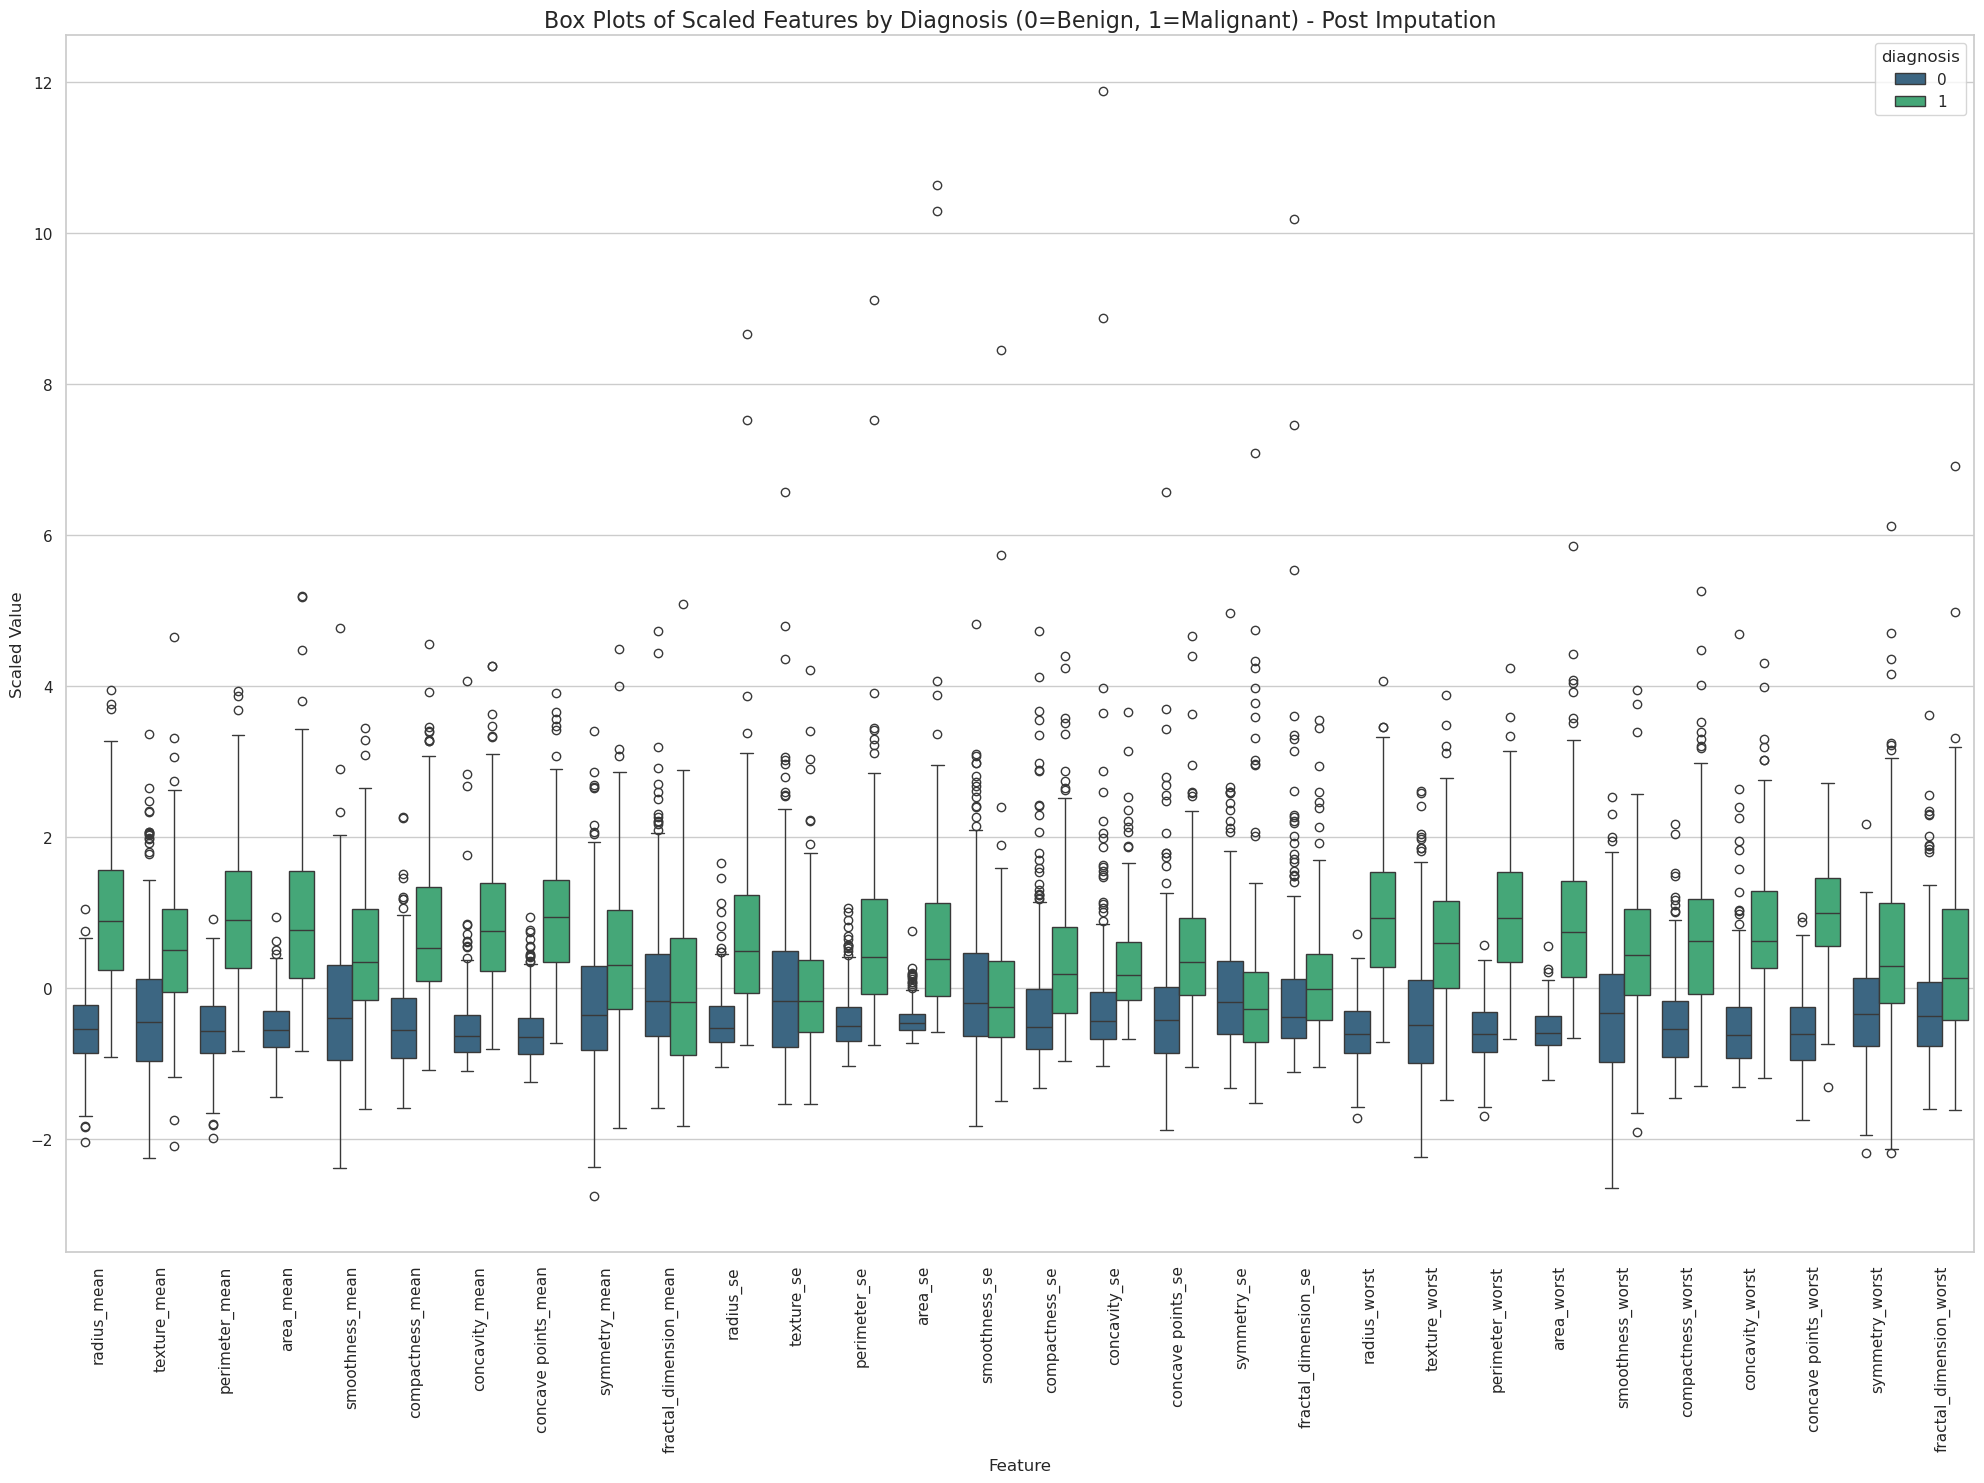

Box plots displayed.

Generating correlation heatmap...


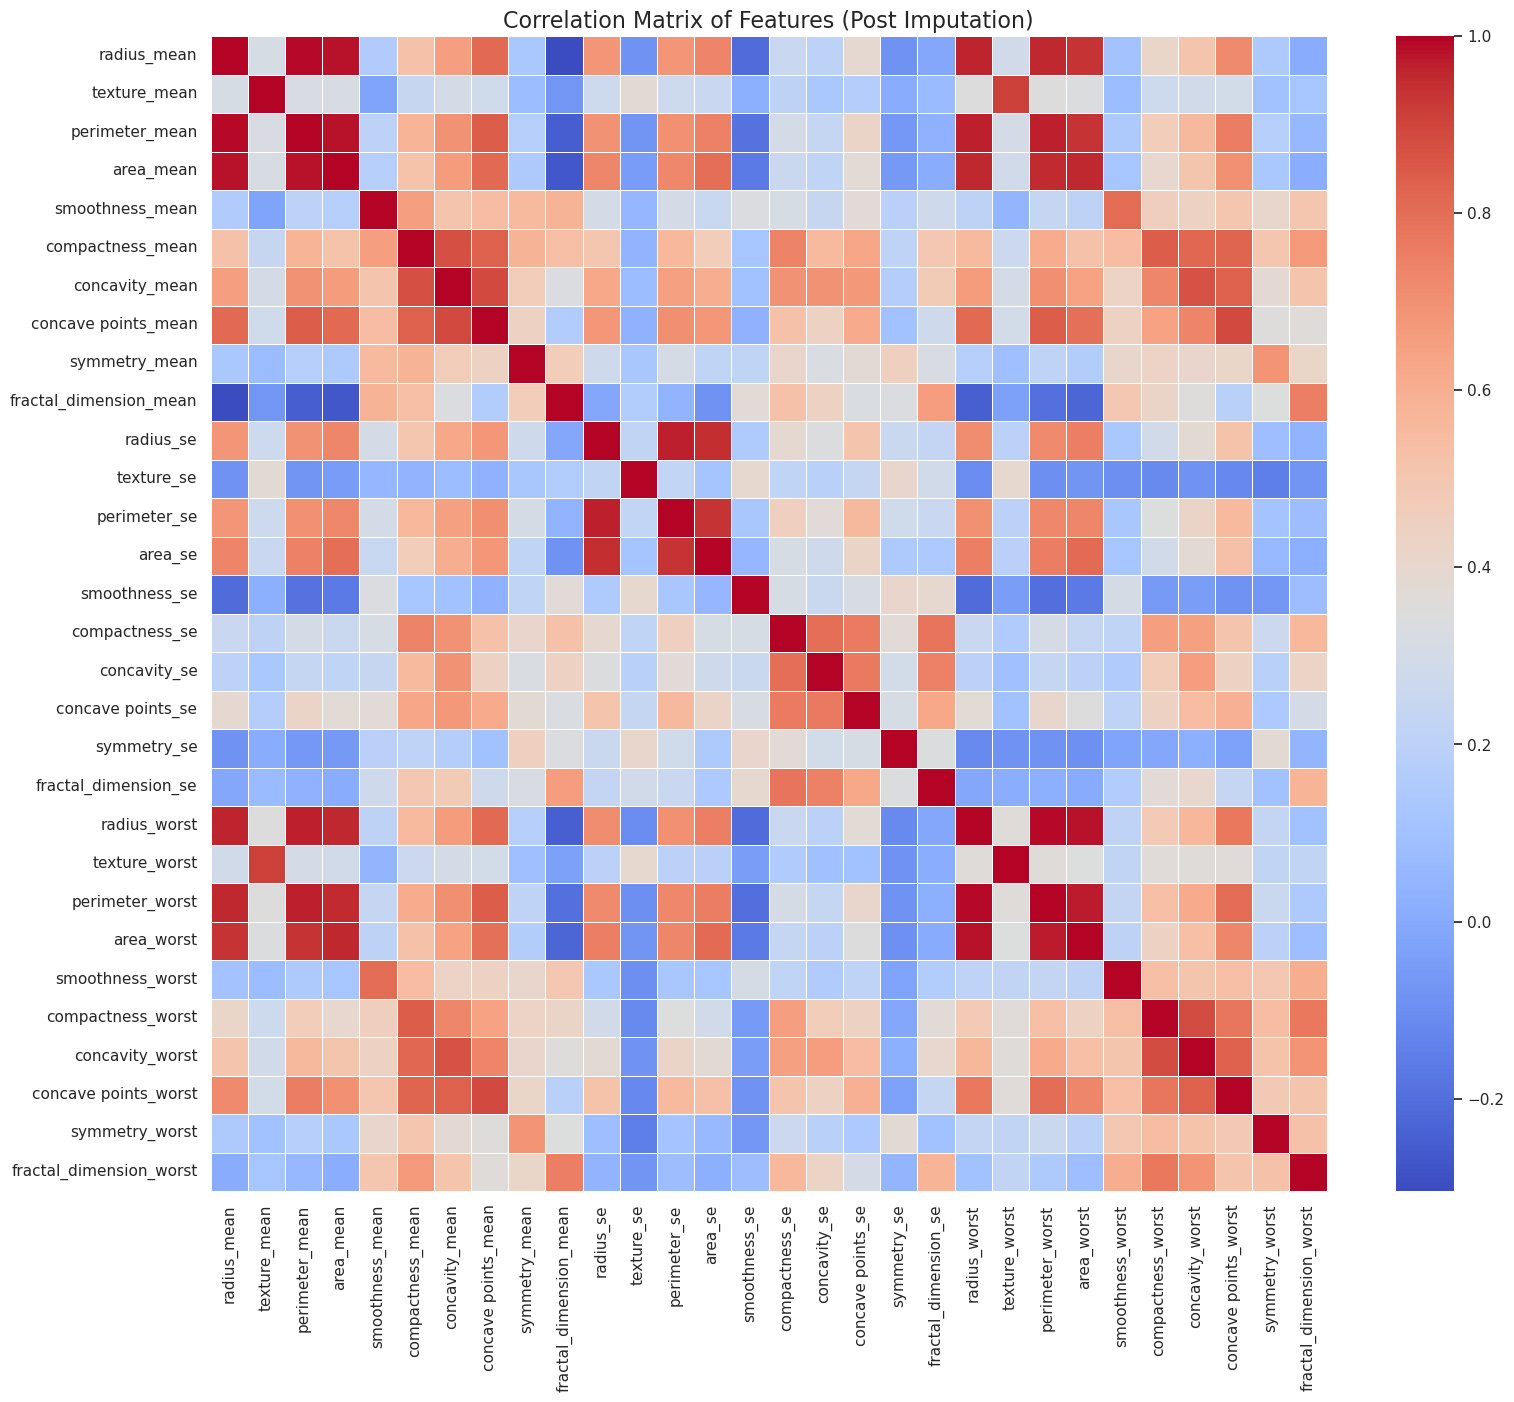

Correlation heatmap displayed.

Highly Correlated Feature Pairs (Threshold > 0.9):
            level_0          level_1  Correlation
1       radius_mean   perimeter_mean     0.991389
46     radius_worst  perimeter_worst     0.990161
10   perimeter_mean        area_mean     0.981690
47     radius_worst       area_worst     0.980544
2       radius_mean        area_mean     0.980435
60       area_worst  perimeter_worst     0.974059
30     perimeter_se        radius_se     0.967830
12   perimeter_mean  perimeter_worst     0.967117
43     radius_worst   perimeter_mean     0.965074
42     radius_worst      radius_mean     0.961586
4       radius_mean  perimeter_worst     0.958071
44     radius_worst        area_mean     0.956710
19        area_mean       area_worst     0.955180
52  perimeter_worst        area_mean     0.954056
28        radius_se          area_se     0.948981
13   perimeter_mean       area_worst     0.938264
34          area_se     perimeter_se     0.937987
56       area_wor

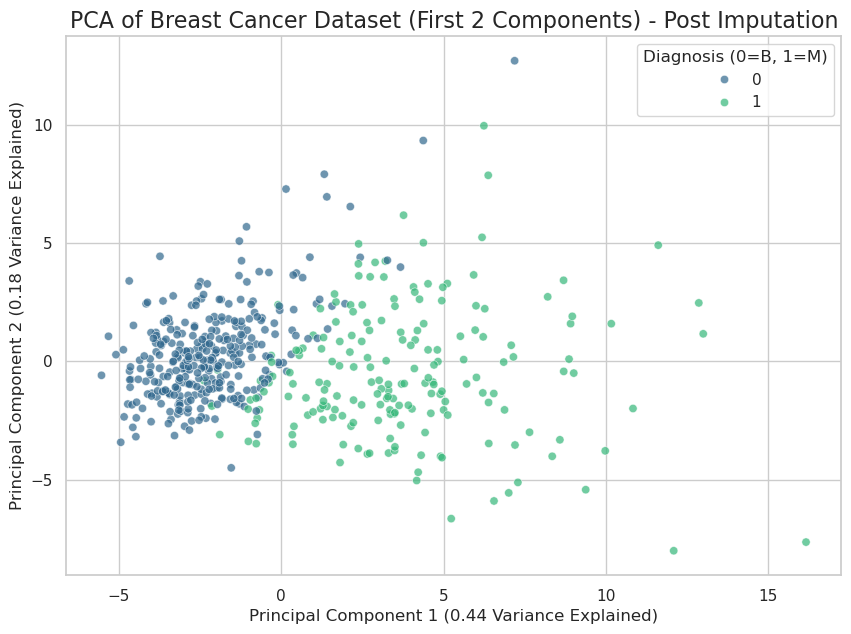

PCA plot displayed. This helps visualize class separability in a lower-dimensional space.


In [6]:
# --- 5. Feature Assessment and Visualization (Using Imputed Data) ---
print("\n--- 5. Feature Assessment and Visualization ---")
print("Using imputed data for the following visualizations.")

# Scale features for visualization (boxplots and PCA)
# Note: Scaling is crucial for distance-based algorithms (like PCA, SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Use the imputed X
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

# a) Box Plots for Feature Distributions (per class)
print("\nGenerating box plots for feature distributions by class...")
plt.figure(figsize=(20, 15)) # Adjust figure size as needed
# Melt the dataframe for easier plotting with seaborn
df_melt = pd.concat([y, X_scaled_df], axis=1)
df_melt = df_melt.melt(id_vars=TARGET_VARIABLE,
                       var_name="Feature",
                       value_name='Scaled Value')

sns.boxplot(x='Feature', y='Scaled Value', hue=TARGET_VARIABLE, data=df_melt, palette='viridis')
plt.title('Box Plots of Scaled Features by Diagnosis (0=Benign, 1=Malignant) - Post Imputation', fontsize=16)
plt.xticks(rotation=90) # Rotate feature names for readability
plt.tight_layout()
plt.show()
print("Box plots displayed.")

# b) Correlation Analysis
print("\nGenerating correlation heatmap...")
plt.figure(figsize=(18, 15))
# Calculate correlation on the imputed, unscaled data for interpretability
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".1f", linewidths=.5) # Annot=True can be slow for many features
plt.title('Correlation Matrix of Features (Post Imputation)', fontsize=16)
plt.show()
print("Correlation heatmap displayed.")

# Find highly correlated pairs (for detailed analysis)
threshold = 0.9 # Example threshold
highly_correlated = correlation_matrix.abs() > threshold
highly_correlated_pairs = correlation_matrix[highly_correlated].stack().reset_index()
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs['level_0'] != highly_correlated_pairs['level_1']]
highly_correlated_pairs['abs_corr'] = highly_correlated_pairs[0].abs()
highly_correlated_pairs = highly_correlated_pairs.sort_values('abs_corr', ascending=False)
# Remove duplicates (pair A-B is same as B-A)
highly_correlated_pairs = highly_correlated_pairs.iloc[::2]
print(f"\nHighly Correlated Feature Pairs (Threshold > {threshold}):")
if not highly_correlated_pairs.empty:
    print(highly_correlated_pairs[['level_0', 'level_1', 0]].rename(columns={0:'Correlation'}))
else:
    print("No feature pairs found above the threshold.")
print("High correlation might indicate multicollinearity, which can affect some models (e.g., Linear Regression).")


# c) Dimensionality Reduction (PCA)
print("\nPerforming PCA and visualizing results...")
pca = PCA(n_components=2) # Reduce to 2 components for visualization
# Use the scaled, imputed data for PCA
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pca_df = pd.concat([pca_df, y], axis=1)

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
print(f"\nExplained Variance Ratio (First 2 components): {explained_variance_ratio}")
print(f"Total Variance Explained by 2 components: {explained_variance_ratio.sum():.2f}")

# Plot PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue=TARGET_VARIABLE,
                palette='viridis', data=pca_df, alpha=0.7)
plt.title('PCA of Breast Cancer Dataset (First 2 Components) - Post Imputation', fontsize=16)
plt.xlabel(f'Principal Component 1 ({explained_variance_ratio[0]:.2f} Variance Explained)')
plt.ylabel(f'Principal Component 2 ({explained_variance_ratio[1]:.2f} Variance Explained)')
plt.legend(title='Diagnosis (0=B, 1=M)')
plt.grid(True)
plt.show()
print("PCA plot displayed. This helps visualize class separability in a lower-dimensional space.")

### 6. Outlier Detection Summary

Provides a summary interpretation based on the box plots generated previously. Highlights the observed outliers and discusses potential handling strategies, emphasizing that the choice depends on context and the models used. It notes the decision (made later for Tasks 3 & 4) to use `RobustScaler` in the modeling pipeline due to these observed outliers.

In [7]:
# --- 6. Outlier Detection (using Box Plots again) ---
print("\n--- 6. Outlier Detection Summary ---")
print("Reviewing the box plots generated in Cell 6 (Section 5a):")
print("- Numerous outliers (points beyond whiskers) are visible across many features.")
print("- Features related to area (e.g., 'area_mean', 'area_se', 'area_worst') and some 'worst' metrics (e.g., 'compactness_worst', 'concavity_worst') show particularly prominent or extreme outliers.")
print("- The presence of these outliers suggests that using RobustScaler (instead of StandardScaler) for preprocessing within the modeling pipeline (Tasks 3 & 4) is advisable, as it's less sensitive to extreme values.")
print("\nPotential Handling Strategies (Considered for Modeling Pipeline):")
print("- Use Robust Models: Tree-based models (Random Forest, LightGBM) are generally less affected by outliers than distance-based models like SVM.")
print("- Use Robust Scaler: Apply RobustScaler during preprocessing (as done in Tasks 3 & 4).")

print("\n--- Exploratory Data Analysis Complete ---")


--- 6. Outlier Detection Summary ---
Reviewing the box plots generated in Cell 6 (Section 5a):
- Numerous outliers (points beyond whiskers) are visible across many features.
- Features related to area (e.g., 'area_mean', 'area_se', 'area_worst') and some 'worst' metrics (e.g., 'compactness_worst', 'concavity_worst') show particularly prominent or extreme outliers.
- The presence of these outliers suggests that using RobustScaler (instead of StandardScaler) for preprocessing within the modeling pipeline (Tasks 3 & 4) is advisable, as it's less sensitive to extreme values.

Potential Handling Strategies (Considered for Modeling Pipeline):
- Use Robust Models: Tree-based models (Random Forest, LightGBM) are generally less affected by outliers than distance-based models like SVM.
- Use Robust Scaler: Apply RobustScaler during preprocessing (as done in Tasks 3 & 4).

--- Exploratory Data Analysis Complete ---
